[Dépôt Git](https://github.com/JeanRosselVallee/project_8.git)

[Application Web](http://localhost:8501/)

# Initialisation

In [1]:
pip install --quiet streamlit plotly mlflow xgboost matplotlib PyQt6 shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --quiet -r ./data/model/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import streamlit as st
import pandas as pd
import numpy as np
import json
import mlflow
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [4]:
dir_in = './data/in/'
dir_out = './data/out/'

# App Web

## Page d'accueil

In [117]:
path_homepage = '🏠_index.py'

In [6]:
ls $path_homepage

 Volume in drive C is System
 Volume Serial Number is 58D0-8386

 Directory of C:\Users\Jean\OCR\git\project_8

05/07/2024  11:57             1,378 Index.py
               1 File(s)          1,378 bytes
               0 Dir(s)   8,266,842,112 bytes free


In [7]:
! type $path_homepage

'''
Index.py
Main page of Streamlit app
'''

import streamlit as st

st.set_page_config(
	page_title="Hello",
	page_icon="ðŸ‘‹",
	layout="wide"	
)

# Customize the sidebar
st.sidebar.title("About")
st.sidebar.info("""
	Web App URL: <https://project8-ocr.streamlit.app/>
	GitHub Repository: <https://github.com/JeanRosselVallee/project_8>
	""")
st.sidebar.image("https://www.whenthebanksaysno.co.uk/wp-content/uploads/2023/05/D9585792-ED4C-4363-900E-1EDCE31B99B1.jpeg")

# Customize page title
st.title("Credit Application Dashboard")

st.markdown(
    """
    This multipage app template demonstrates various interactive web apps created using [streamlit](https://streamlit.io) and [leafmap](https://leafmap.org). It is an open-source project and you are very welcome to contribute to the [GitHub repository](https://github.com/giswqs/streamlit-multipage-template).
    """
)

st.header("Instructions")

markdown = """
1. Select a client's application for credit
2. Find your favorite emoji from http

## Serveur local

### Arrêt

In [124]:
! taskkill /IM streamlit.exe /F

SUCCESS: The process "streamlit.exe" with PID 10932 has been terminated.


### Démarrage

In [125]:
# ! conda env list

In [126]:
shell_command = 'start /b streamlit run ' + path_homepage + ' > ./log/streamlit_app.log 2>&1 &'
print('shell_command =', shell_command)
get_ipython().system_raw(shell_command) # run model API in background

shell_command = start /b streamlit run 🏠_index.py > ./log/streamlit_app.log 2>&1 &


### Vérification

In [127]:
! powershell "Get-Process | Where-Object { $_.ProcessName -like '*streamlit*' }"


Handles  NPM(K)    PM(K)      WS(K)     CPU(s)     Id  SI ProcessName                                                  
-------  ------    -----      -----     ------     --  -- -----------                                                  
     92       5      700       3440       0.00  14608   1 streamlit                                                    




## Log

In [119]:
! powershell -command "type ./log/streamlit_app.log -Tail 10"


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.108:8501



# Jeu de données

Les prédictions se feront sur le jeu de test parce que le modèle a été entraîné sur celui d'entraînement

In [11]:
ls "../project_7/modeling/data/out/*test_2.csv" "../project_7/modeling/data/out/*pred*.csv"

 Volume in drive C is System
 Volume Serial Number is 58D0-8386

 Directory of C:\Users\Jean\OCR\git\project_7\modeling\data\out


 Directory of C:\Users\Jean\OCR\git\project_7\modeling\data\out



File Not Found


cp ../project_7/modeling/data/out/*_test_2.csv ./data/in/

cp ../project_7/test_api/data/li_features.txt ./data/in/

In [12]:
! dir /b "./data/in/"

config.json
data.csv
li_features.txt
model_optimal_simplified.json
X_test_2.csv
X_TN.csv
X_TP.csv
y_pred_4.csv
y_test_2.csv


In [13]:
! for /f "delims=" %f in ('dir /b data\in\*') do @find /c /v "" "data\in\%f"


---------- DATA\IN\CONFIG.JSON: 9

---------- DATA\IN\DATA.CSV: 48679

---------- DATA\IN\LI_FEATURES.TXT: 1

---------- DATA\IN\MODEL_OPTIMAL_SIMPLIFIED.JSON: 1

---------- DATA\IN\X_TEST_2.CSV: 48679

---------- DATA\IN\X_TN.CSV: 33121

---------- DATA\IN\X_TP.CSV: 2359

---------- DATA\IN\Y_PRED_4.CSV: 48679

---------- DATA\IN\Y_TEST_2.CSV: 48679


### Chargement

In [14]:
def load_data(file):
    df_contents = pd.read_csv(file)   .rename(columns={'Unnamed: 0': 'request_id'}) \
                                      .set_index('request_id')
    return df_contents

#### Attributs

In [15]:
path_X = dir_in + 'X_test_2.csv'
df_X = load_data(path_X)
df_X.shape

(48678, 125)

In [16]:
with open(dir_in + 'li_features.txt') as f :
    str_li_features = f.read()
li_features = eval(str_li_features)
li_features

['CODE_GENDER_M',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'NAME_EDUCATION_TYPE_Secondary_or_secondary_special',
 'NAME_EDUCATION_TYPE_Higher_education',
 'NAME_CONTRACT_TYPE_Cash_loans',
 'NAME_INCOME_TYPE_Working']

In [17]:
df_X = df_X[li_features]
display(df_X.head(1))
df_X.shape

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
request_id,,,,,,,
155094,0,0.770087,0.607697,0,1,1,0


(48678, 7)

#### Matrice de corrélation

In [18]:
def mask_upper_triangle(df_in) :
    ''' Fills a diagonal and the upper half with NaNs '''
    mask = np.zeros_like(df_in, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    df_in[mask] = np.nan
    return df_in

In [19]:
threshold_hide_low = 0.1
df_correlation_matrix = df_X.corr()
df_correlation_matrix[np.abs(df_correlation_matrix)<=threshold_hide_low] = 0
li_correlated_cols = list(df_correlation_matrix  .columns[(abs(df_correlation_matrix).sum()>1)])
mask_upper_triangle(df_correlation_matrix.loc[li_correlated_cols, li_correlated_cols]) \
              .style.format('{:.1f}').background_gradient(axis=None, cmap='RdYlGn')

,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_INCOME_TYPE_Working
EXT_SOURCE_3,nan,nan,nan,nan,nan
EXT_SOURCE_2,0.1,nan,nan,nan,nan
NAME_EDUCATION_TYPE_Secondary_or_secondary_special,0.0,-0.1,nan,nan,nan
NAME_EDUCATION_TYPE_Higher_education,0.0,0.1,-0.9,nan,nan
NAME_INCOME_TYPE_Working,0.0,0.0,0.2,-0.2,nan


In [20]:
df_correlation_matrix = df_X.corr()
mask_upper_triangle(df_correlation_matrix) \
                .style.format('{:.1f}').background_gradient(axis=None, cmap='RdYlGn') \
                .set_properties(**{'color': 'black'})#.text_gradient(cmap='black')

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
CODE_GENDER_M,nan,nan,nan,nan,nan,nan,nan
EXT_SOURCE_3,-0.0,nan,nan,nan,nan,nan,nan
EXT_SOURCE_2,-0.0,0.1,nan,nan,nan,nan,nan
NAME_EDUCATION_TYPE_Secondary_or_secondary_special,0.0,0.0,-0.1,nan,nan,nan,nan
NAME_EDUCATION_TYPE_Higher_education,-0.0,-0.0,0.1,-0.9,nan,nan,nan
NAME_CONTRACT_TYPE_Cash_loans,0.0,-0.0,-0.0,0.1,-0.1,nan,nan
NAME_INCOME_TYPE_Working,0.0,-0.0,-0.1,0.2,-0.2,0.0,nan


In [21]:
df_correlation_matrix.loc['NAME_EDUCATION_TYPE_Higher_education']['NAME_EDUCATION_TYPE_Secondary_or_secondary_special']

-0.8991237664959102

In [22]:
df_correlation_matrix.loc[['NAME_EDUCATION_TYPE_Higher_education']][['NAME_EDUCATION_TYPE_Secondary_or_secondary_special']]

,NAME_EDUCATION_TYPE_Secondary_or_secondary_special
NAME_EDUCATION_TYPE_Higher_education,-0.899124


In [23]:
df_correlation_matrix = df_X.corr()
df_correlation_matrix.loc[['NAME_EDUCATION_TYPE_Higher_education']][['NAME_EDUCATION_TYPE_Secondary_or_secondary_special']] \
                .style.format('{:.1f}').background_gradient(axis=None, cmap='RdYlGn')
                #.set_properties(**{'color': 'black'})

,NAME_EDUCATION_TYPE_Secondary_or_secondary_special
NAME_EDUCATION_TYPE_Higher_education,-0.9


#### Cible

In [24]:
path_y = dir_in + 'y_test_2.csv'
df_y = load_data(path_y)
df_y.shape
display(df_y.head(1))

,TARGET
request_id,
155094,0


### Jointure d'attributs et cible

In [25]:
li_features_simplified  = ['male', 'score_A', 'score_B', 'edu_level_2', 'edu_level_3', 'cash_loan', 'employee']
li_variables_simplified = li_features_simplified + ['class']

In [26]:
df_data = df_X.join(df_y)
#df_data.columns = li_variables_simplified

In [27]:
display(df_data.head(1))
df_data.shape

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working,TARGET
request_id,,,,,,,,
155094,0,0.770087,0.607697,0,1,1,0,0


(48678, 8)

### Distribution d'attributs par classe

#### Observations de classe 0

In [28]:
df_data_0 = df_data[df_data['TARGET']==0]
df_data_1 = df_data[df_data['TARGET']==1]
df_data_0.head(1)

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working,TARGET
request_id,,,,,,,,
155094,0,0.770087,0.607697,0,1,1,0,0


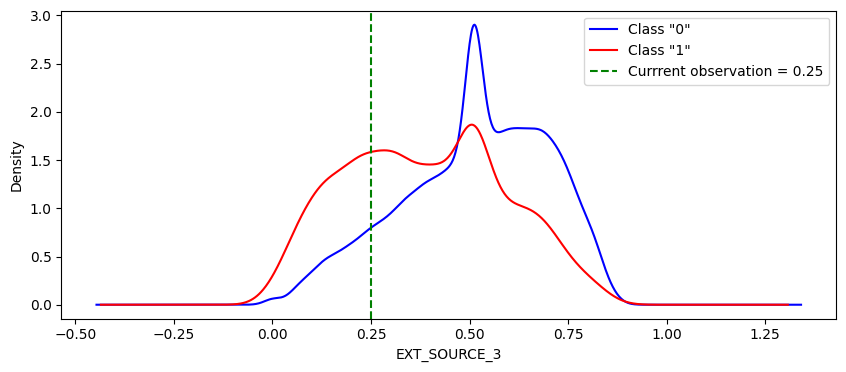

In [80]:
%matplotlib inline
x_curr = 0.25
str_feature = 'EXT_SOURCE_3'
fig, ax = plt.subplots(figsize=(10, 4))
df_data_0[str_feature].plot.kde(ax=ax, color='blue', label='Class "0"')
df_data_1[str_feature].plot.kde(ax=ax, color='red' , label='Class "1"')
ax.axvline(x=x_curr, color='green', linestyle='--', label=f'Currrent observation = {x_curr}')
ax.legend()
ax.set_xlabel(str_feature)
plt.show()

In [30]:
df_data_0['TARGET'].value_counts()

TARGET
0    44769
Name: count, dtype: int64

### Sauvegarde

In [31]:
df_data.to_csv(dir_in + 'data.csv')

In [32]:
! dir /b "$dir_in\data.csv"

data.csv


In [33]:
! powershell -command "type $dir_in/data.csv -Head 3"

request_id,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working,TARGET
155094,0,0.7700870700124128,0.6076973714617412,0,1,1,0,0
74108,0,0.4258928980051529,0.7318427244611323,1,0,1,1,0


# Score normalisé

L'affichage sur la jauge a besoin d'un score normalisé par rapport au seuil entre les 2 classes:
|score original|score normalisé|
|--|--|
|0|0|
|seuil S|0.5|
|1|1|

On obtient ces résultats en élévant le score à la puissance P

$$ T ^ P = 0.50 \quad \quad \quad \text{where T : threshold} $$
$$ \Rightarrow \quad P = \frac{\log_{2}(0.50)}{\log_{2}(threshold)} = -\frac{1}{\log_{2}(threshold)} $$


In [34]:
def get_normalizing_power(threshold) :
	normalizing_power = - 1 / np.log2(threshold)
	return normalizing_power

# Modèle adapté

In [35]:
from xgboost import XGBClassifier

## Classe du modèle

Le score renvoyé est la probabilité qu'un emprunteur ne rembourse pas (classe "1")

In [36]:
class XGB_prob(XGBClassifier):
    threshold = 0 
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
    def fit(self, df_X_train, df_y_train, **kwargs) : 
        super().fit(df_X_train, df_y_train, **kwargs)
    def predict(self, df_X_subset, bool_save_events=True):      
        np_y_pred_proba = super().predict_proba(df_X_subset)[:, 1]  # class 1 probas  
        np_y_normalized = np.power(np_y_pred_proba, get_normalizing_power(self.threshold))
        return np_y_normalized

## Récupération

On importe le modèle de prédiction le plus récent: celui deployé en pré-Prod car celui en Prod est absent du dépôt Git

In [37]:
path_config = '../config.json' 

In [38]:
# cp ../project_7/config.json ./data/in/

In [39]:
# cp ../project_7/modeling/data/out/model_optimal_simplified.json ./data/in/

In [40]:
model_prob = XGB_prob()
model_prob.load_model(dir_in + 'model_optimal_simplified.json')
model_prob

XGB_prob(base_score='1.572525E-1', booster='gbtree', callbacks=None,
         colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
         device=None, early_stopping_rounds=None, enable_categorical=False,
         eval_metric=None,
         feature_types=['int', 'float', 'float', 'int', 'int', 'int', 'int'],
         gamma=None, grow_policy=None, importance_type=None,
         interaction_constraints=None, learning_rate=None, max_bin=None,
         max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
         max_depth=None, max_leaves=None, min_child_weight=None, missing=nan,
         monotone_constraints=None, multi_strategy=None, n_estimators=None,
         n_jobs=None, num_parallel_tree=None, objective='binary:logistic', ...)

### Génération de signature

In [41]:
from mlflow.models.signature import infer_signature

In [42]:
model_signature = infer_signature(df_X.head(1), df_y.head(1))

C:\Users\Jean\anaconda3\envs\env_ocr_projet_8\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


#### Attributs

In [43]:
list(model_signature.inputs)[:10]

['CODE_GENDER_M': long (required),
 'EXT_SOURCE_3': double (required),
 'EXT_SOURCE_2': double (required),
 'NAME_EDUCATION_TYPE_Secondary_or_secondary_special': long (required),
 'NAME_EDUCATION_TYPE_Higher_education': long (required),
 'NAME_CONTRACT_TYPE_Cash_loans': long (required),
 'NAME_INCOME_TYPE_Working': long (required)]

#### Cible

In [44]:
list(model_signature.outputs)

['TARGET': long (required)]

### Mise à jour du seuil binaire

In [45]:
dict_params_old = model_prob.get_params()
dict_params_old['threshold']

0.5

In [46]:
with open(dir_in + 'config.json', 'r') as json_file: dict_to_config = json.load(json_file)
best_threshold = float(dict_to_config['best_threshold'])

In [47]:
setattr(model_prob, 'threshold', best_threshold)

In [48]:
dict_params_new = model_prob.get_params()
dict_params_new['threshold']

0.09

## Déploiement

In [49]:
from mlflow import sklearn as skl

In [50]:
model_path = './data/model/'
#! rmdir /s /q "$model_path"
#! mkdir "$model_path"

In [51]:
#%time skl.save_model(model_prob, model_path, signature=model_signature)

#### Fichiers générés

In [52]:
! dir /b "$model_path"

conda.yaml
MLmodel
model.pkl
python_env.yaml
requirements.txt


### Prédictions

In [53]:
np_y_pred_proba = model_prob.predict(df_X)

In [54]:
np_y_pred_proba

array([0.32588145, 0.4276271 , 0.4159582 , ..., 0.31557882, 0.49494374,
       0.53514314], dtype=float32)

In [55]:
# np.save(dir_out + 'y_pred_proba', np_y_pred_proba)

In [56]:
np.load(dir_out + 'y_pred_proba.npy')

array([0.32588145, 0.4276271 , 0.4159582 , ..., 0.31557882, 0.49494374,
       0.53514314], dtype=float32)

### Nuage de points colorié

In [57]:
def spread_out(df_in, str_A, str_B, radius) :
    df_out_A = df_in[str_A] + np.random.normal(0, radius, size=df_in.shape[0])
    df_out_B = df_in[str_B] + np.random.normal(0, radius, size=df_in.shape[0])
    return df_out_A, df_out_B

In [58]:
str_x = 'NAME_EDUCATION_TYPE_Higher_education'
str_y = 'NAME_EDUCATION_TYPE_Secondary_or_secondary_special'
df_A , df_B = spread_out(df_X, str_x, str_x, radius = 0.15)

In [59]:
def make_cmap(bottom, low, high, top) : 
    li_colored_levels = [(0, bottom), (0.49, low), (0.51, high), (1, top)]
    return LinearSegmentedColormap.from_list('CustomMap', li_colored_levels)

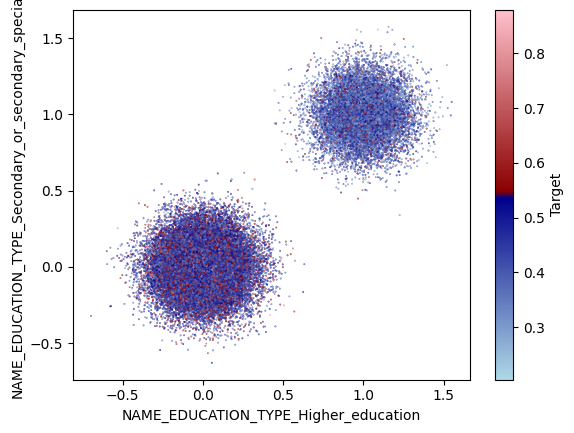

In [81]:
%matplotlib inline
scatter_A_B = plt.scatter(df_A, df_B, c=np_y_pred_proba, s=.1, alpha=1, 
                          cmap=make_cmap('lightblue', 'darkblue', 'darkred', 'pink'))
plt.xlabel(str_x), plt.ylabel(str_y)
cbar = plt.colorbar(scatter_A_B, label='Target')
plt.show()

# Mise en service

## Arrêt

In [61]:
port_server = '5677'

In [62]:
mask = ':' + port_server
! taskkill /IM *"$mask"*

ERROR: The process "*:5677*" not found.


## Démarrage

In [63]:
ip_host = '0.0.0.0'
shell_command =  'mlflow models serve -m '
shell_command += model_path + ' -p ' + port_server + ' -h ' + ip_host #+ ' --env-manager=conda'
print(shell_command)

mlflow models serve -m ./data/model/ -p 5677 -h 0.0.0.0


In [64]:
get_ipython().system_raw('start /b mlflow models serve -m ./data/model/ -p 5677 -h 0.0.0.0 --no-conda &')          # runs model API in background

## Vérification d'exécution

Il y a 2 processus qui tournent par serveur

In [66]:
! powershell "Get-Process | Where-Object { $_.ProcessName -like '*mlflow*' }"


Handles  NPM(K)    PM(K)      WS(K)     CPU(s)     Id  SI ProcessName                                                  
-------  ------    -----      -----     ------     --  -- -----------                                                  
     86       5      684       3436       0.02   5220   1 mlflow                                                       
     90       5      708       3436       0.03   9212   1 mlflow                                                       
     84       5      656       3420       0.00  11028   1 mlflow                                                       
     84       5      660       3424       0.00  13240   1 mlflow                                                       




# Tests

In [67]:
url_api = 'localhost:' + port_server + '/invocations'
print('URL API    -> http://' + url_api)

URL API    -> http://localhost:5677/invocations


## Prédictions

Demande par requête POST de prédiction de la cible pour une observation

In [68]:
#cp ../project_7/modeling/data/out/X_T[PN].csv ./data/in/

In [69]:
nb_observations = 10

### Cas TP

In [70]:
path_TP = dir_in + 'X_TP.csv'
df_TP = pd.read_csv(path_TP)

In [71]:
df_TP_sample = df_TP.sample(nb_observations)
df_TP_sample

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
1310,1,0.231439,0.518581,1,0,1,1
909,1,0.225087,0.267217,1,0,1,1
1327,0,0.401407,0.299441,1,0,1,1
1645,1,0.595456,0.222627,1,0,1,1
208,1,0.294083,0.289838,1,0,1,1
1119,0,0.513694,0.127765,1,0,1,0
143,1,0.074959,0.263254,1,0,1,0
1585,0,0.148254,0.002622,0,0,1,0
567,0,0.616122,0.028954,1,0,1,1
1428,0,0.510853,0.076958,1,0,1,1


In [72]:
def get_curl_command(df_sample, url) :
    str_features_values = df_sample.to_json(orient='split')
    str_data = '\'{"dataframe_split": ' + str_features_values + '}\' '
    return 'curl -d' + str_data + '''-H 'Content-Type: application/json' -X POST ''' + url

Vérifier que cette ligne de commande Linux renvoie une prédiction de classe "1"

In [73]:
shell_command = get_curl_command(df_TP_sample, url_api).replace('"', '\\"').replace('\'', '"')
print(shell_command)

curl -d"{\"dataframe_split\": {\"columns\":[\"CODE_GENDER_M\",\"EXT_SOURCE_3\",\"EXT_SOURCE_2\",\"NAME_EDUCATION_TYPE_Secondary_or_secondary_special\",\"NAME_EDUCATION_TYPE_Higher_education\",\"NAME_CONTRACT_TYPE_Cash_loans\",\"NAME_INCOME_TYPE_Working\"],\"index\":[1310,909,1327,1645,208,1119,143,1585,567,1428],\"data\":[[1,0.2314393515,0.5185807682,1,0,1,1],[1,0.2250868621,0.2672171519,1,0,1,1],[0,0.4014074138,0.299440509,1,0,1,1],[1,0.5954562029,0.2226266539,1,0,1,1],[1,0.2940831009,0.2898382552,1,0,1,1],[0,0.5136937663,0.1277653872,1,0,1,0],[1,0.0749592809,0.2632538486,1,0,1,0],[0,0.1482543791,0.0026224485,0,0,1,0],[0,0.6161216909,0.0289544963,1,0,1,1],[0,0.5108529062,0.0769581907,1,0,1,1]]}}" -H "Content-Type: application/json" -X POST localhost:5677/invocations


In [74]:
! $shell_command

{"predictions": [0.6310693025588989, 0.6936975717544556, 0.5697752833366394, 0.5357540845870972, 0.6506482362747192, 0.5532046556472778, 0.755084753036499, 0.786758303642273, 0.5832767486572266, 0.5999460220336914]}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   890  100   215  100   675  18394  57751 --:--:-- --:--:-- --:--:-- 80909


### Cas TN

In [75]:
path_TN = dir_in + 'X_TN.csv'
df_TN = pd.read_csv(path_TN)

In [76]:
df_TN_sample = df_TN.sample(nb_observations)
df_TN_sample

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
25456,0,0.638044,0.642209,1,0,1,0
21899,1,0.540654,0.648405,1,0,1,1
32330,1,0.563835,0.728776,1,0,1,1
7495,0,0.524496,0.644151,1,0,1,1
2971,1,0.803885,0.741455,1,0,1,1
12764,0,0.355639,0.634536,0,1,1,1
3479,1,0.448962,0.732366,0,1,1,0
17703,1,0.567379,0.496798,0,1,1,0
694,1,0.646330,0.690659,1,0,1,1
27634,1,0.718033,0.680958,1,0,1,0


Vérifier que cette ligne de commande Linux renvoie une prédiction de classe "0"

In [77]:
shell_command = get_curl_command(df_TN_sample, url_api).replace('"', '\\"').replace('\'', '"')
print(shell_command)

curl -d"{\"dataframe_split\": {\"columns\":[\"CODE_GENDER_M\",\"EXT_SOURCE_3\",\"EXT_SOURCE_2\",\"NAME_EDUCATION_TYPE_Secondary_or_secondary_special\",\"NAME_EDUCATION_TYPE_Higher_education\",\"NAME_CONTRACT_TYPE_Cash_loans\",\"NAME_INCOME_TYPE_Working\"],\"index\":[25456,21899,32330,7495,2971,12764,3479,17703,694,27634],\"data\":[[0,0.6380435279,0.6422091342,1,0,1,0],[1,0.5406544504,0.6484054271,1,0,1,1],[1,0.563835049,0.7287761761,1,0,1,1],[0,0.5244964464,0.6441513278,1,0,1,1],[1,0.8038850612,0.7414548478,1,0,1,1],[0,0.355638717,0.6345360912,0,1,1,1],[1,0.4489622731,0.7323659623,0,1,1,0],[1,0.5673792368,0.4967983265,0,1,1,0],[1,0.6463298977,0.690659395,1,0,1,1],[1,0.7180328113,0.6809581321,1,0,1,0]]}}" -H "Content-Type: application/json" -X POST localhost:5677/invocations


In [78]:
! $shell_command

{"predictions": [0.36836203932762146, 0.44945982098579407, 0.4070330560207367, 0.41762587428092957, 0.3338598310947418, 0.4253306984901428, 0.3692811131477356, 0.3968387544155121, 0.3877604603767395, 0.36358898878097534]}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   903  100   221  100   682  12118  37398 --:--:-- --:--:-- --:--:-- 50166


# Feature Importance

#### Entraînement

In [82]:
# model_prob.fit(df_X_train_simplified, df_y_train)

## Valeurs Shapley 

In [83]:
import shap

C:\Users\Jean\anaconda3\envs\env_ocr_projet_8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [84]:
explainer = shap.TreeExplainer(model_prob)
np_shap_values = explainer.shap_values(df_X)

In [85]:
# np.save(dir_out + 'shap_values', np_shap_values)

In [86]:
np.load(dir_out + 'shap_values.npy')

array([[-0.10604649, -0.73416895, -0.15025097, ..., -0.2882225 ,
         0.04021755, -0.10489687],
       [-0.10604649,  0.19571878, -0.69649756, ...,  0.08824793,
         0.04021755,  0.052944  ],
       [-0.10604649, -0.5690576 , -0.03287617, ...,  0.08824793,
         0.04021755,  0.052944  ],
       ...,
       [-0.10604649, -0.5690576 , -0.58699477, ..., -0.2882225 ,
         0.04021755,  0.052944  ],
       [-0.10604649,  0.5163189 , -0.31420535, ...,  0.08824793,
         0.04021755, -0.10489687],
       [-0.10604649, -0.41659302,  0.7622442 , ...,  0.08824793,
         0.04021755,  0.052944  ]], dtype=float32)

## Explicateur d'attributs 

In [87]:
explainer_X = explainer(df_X)

In [90]:
import pickle

In [91]:
#with open(dir_out + 'explainer_X.pkl', 'wb') as f:
#    pickle.dump(explainer_X, f)

In [92]:
with open(dir_out + 'explainer_X.pkl', 'rb') as f:
    loaded_explainer = pickle.load(f)
type(loaded_explainer)

shap._explanation.Explanation

## Importance Globale

- appliqué au jeu de test

### Graphe de violons

**Guide d'analyse des "violons"**
- Les attributs sont triés par ordre d'importance décroissante
- Pour chaque attribut, on indique :
    - la grandeur des valeurs 
        - faibles en bleu
        - importantes en rouge
    - leur distribution par la hauteur des traits
    - leur effet sur le score (axe X)
        - négatif
        - positif

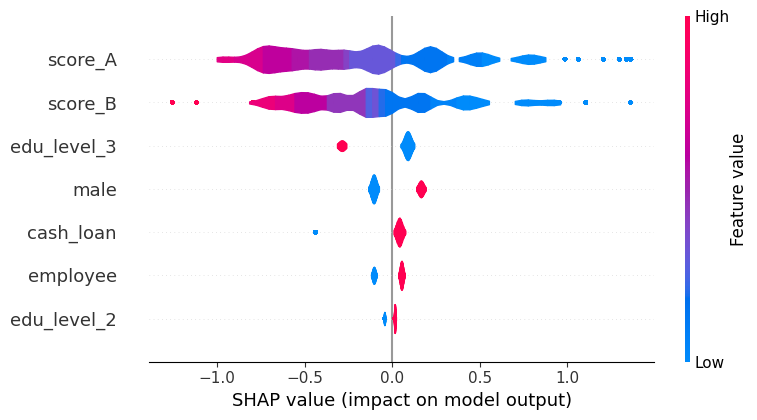

In [93]:
shap.summary_plot(np_shap_values, df_X, feature_names=li_features_simplified, plot_type='violin')

**Interprétation**
1. Effets
    - Les scores fournis par des sources externes sont les plus influents
    - Pour être classé en mauvais emprunteur il faudrait :
        - des valeurs faibles de scores externes 
        - pas d'éducation supérieure
        - être un homme
        - demander un retrait du prêt en espèces
        - être salarié
        - avoir une éducation secondaire
    -  Cas à fort impact négatif 
        -  ne pas demander un retrait en espèces
        -  avoir une éducation supérieure
2. Distribution 
    - Observations majoritaires :        
        - des valeurs fortes de scores fournis par des sources externes 
        - pas d'éducation supérieure
        - des femmes
        - demandes de retrait du prêt en espèces
        - être salarié
        - éducation secondaire

## Importance Locale

### Graphe en cascade d'un échantillon

**Interprétation**

Pour interpréter ce graphe, on se déplace du bas vers le haut :
- on démarre en bas du diagramme avec la valeur de base E(f(x)] en gris 
- on remontant les lignes, on additionne progresivement à cette valeur, les valeurs _SHAP_ de chaque attribut
- les flèches rouges ont un impact positif et les bleues négatif
    - leur taille indique leur importance locale
    - on constate que l'ordre d'importance des attributs varie
- l'addition résultante indique l'appartenance à une classe
    - classe "0", si résultat négatif
    - classe "1", si positif

In [94]:
print('median_predicted_value E[f(x)]=', explainer.expected_value)


median_predicted_value E[f(x)]= -2.4865499


In [98]:
pd.DataFrame(df_X.iloc[0]).T

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
155094,0.0,0.770087,0.607697,0.0,1.0,1.0,0.0


Expected class= 0
predicted probability= [0.32588145]


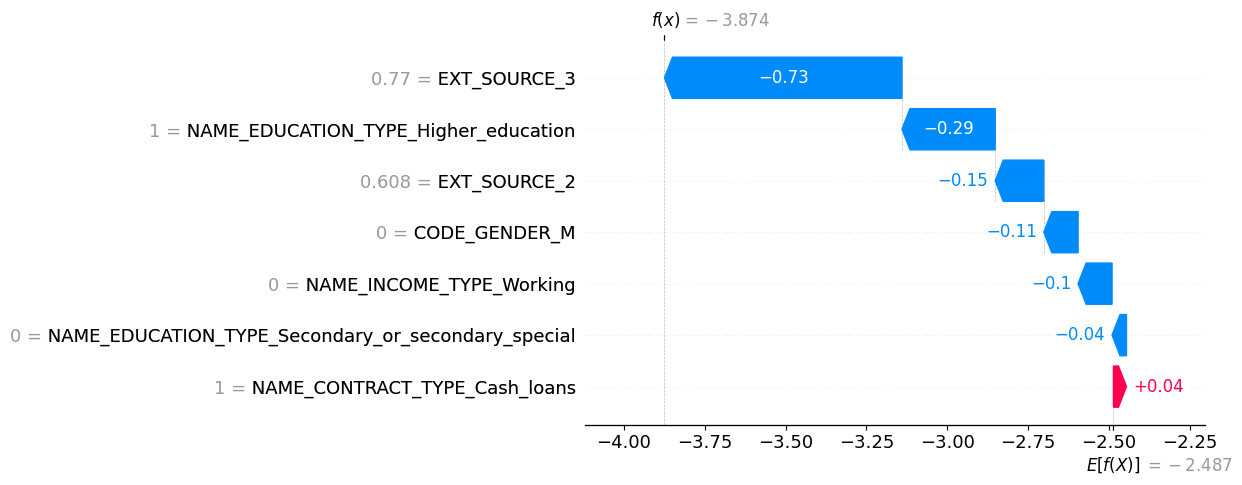

Expected class= 0
predicted probability= [0.4276271]


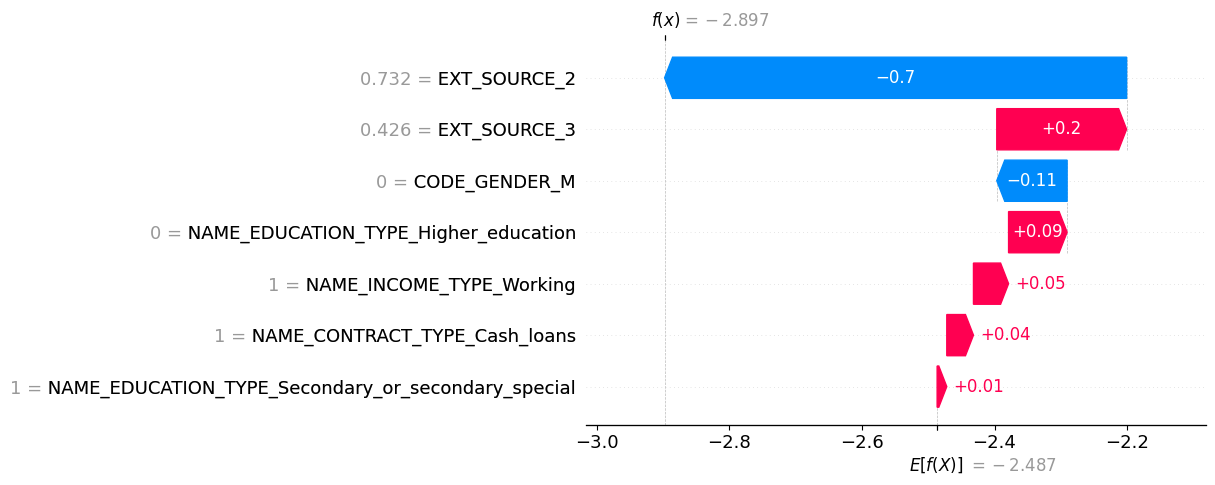

Expected class= 0
predicted probability= [0.4159582]


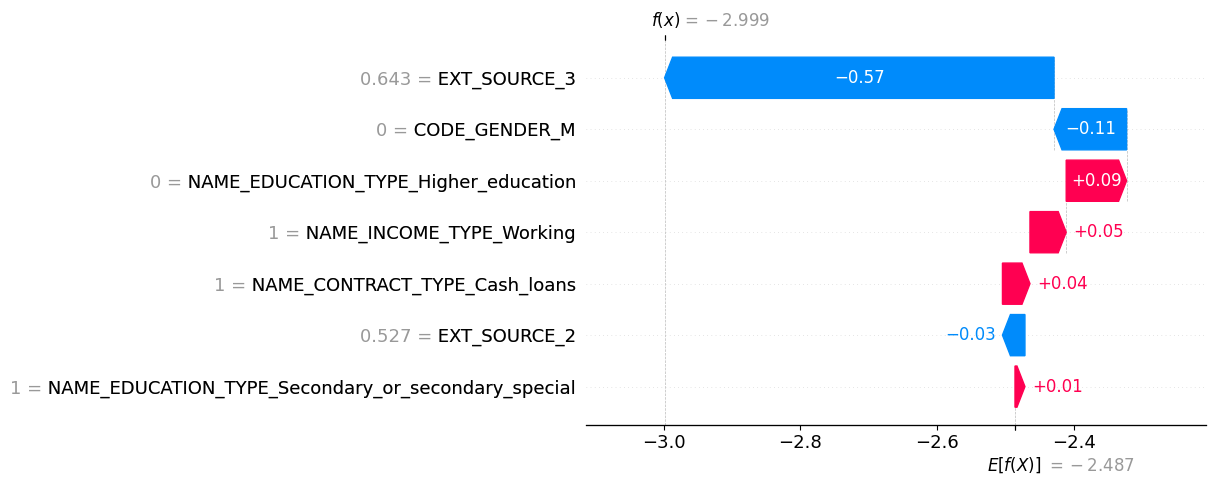

Expected class= 1
predicted probability= [0.6140911]


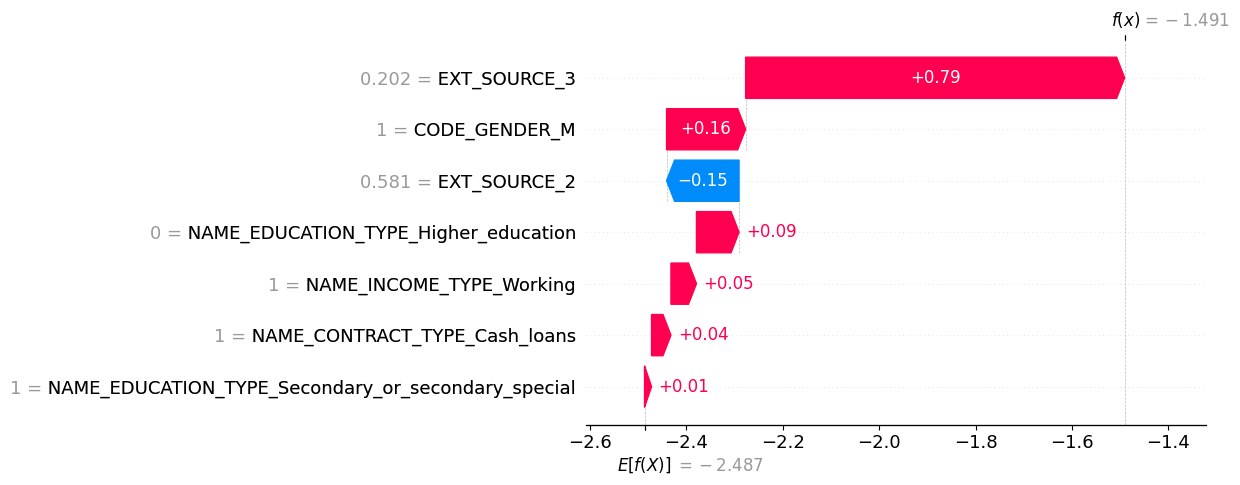

Expected class= 0
predicted probability= [0.45901853]


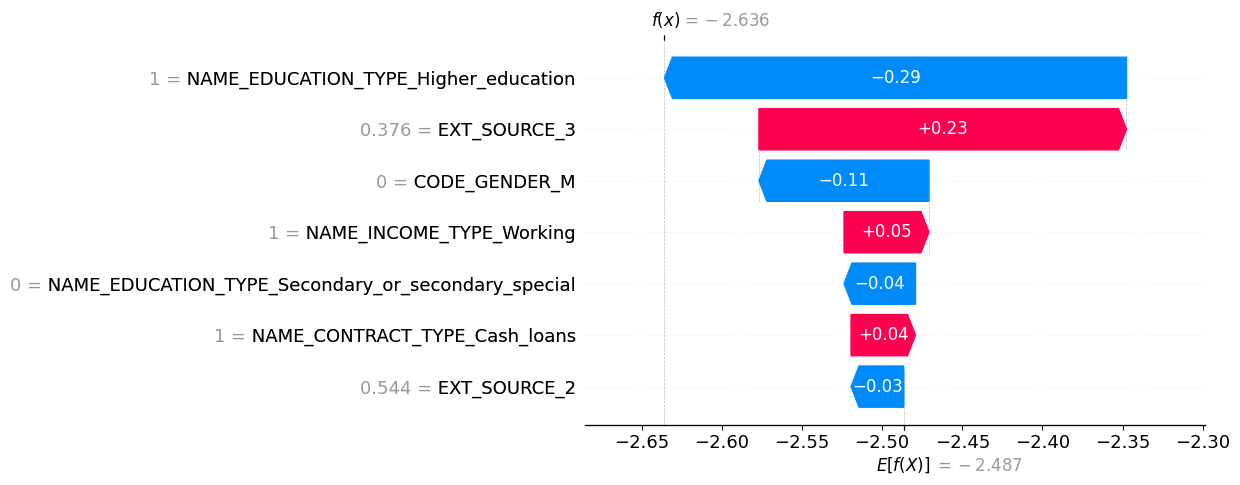

Expected class= 0
predicted probability= [0.3379564]


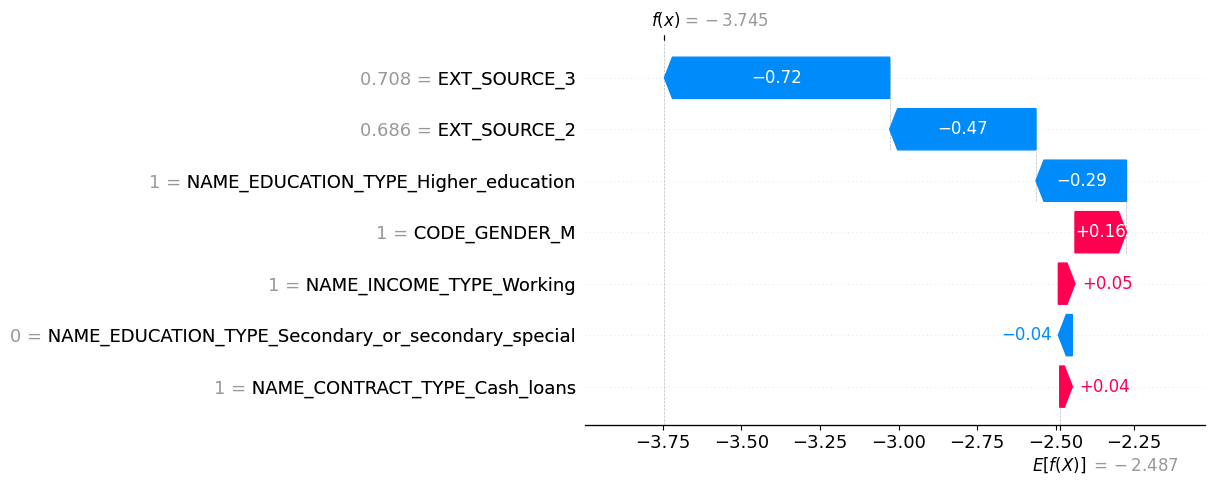

Expected class= 1
predicted probability= [0.44359335]


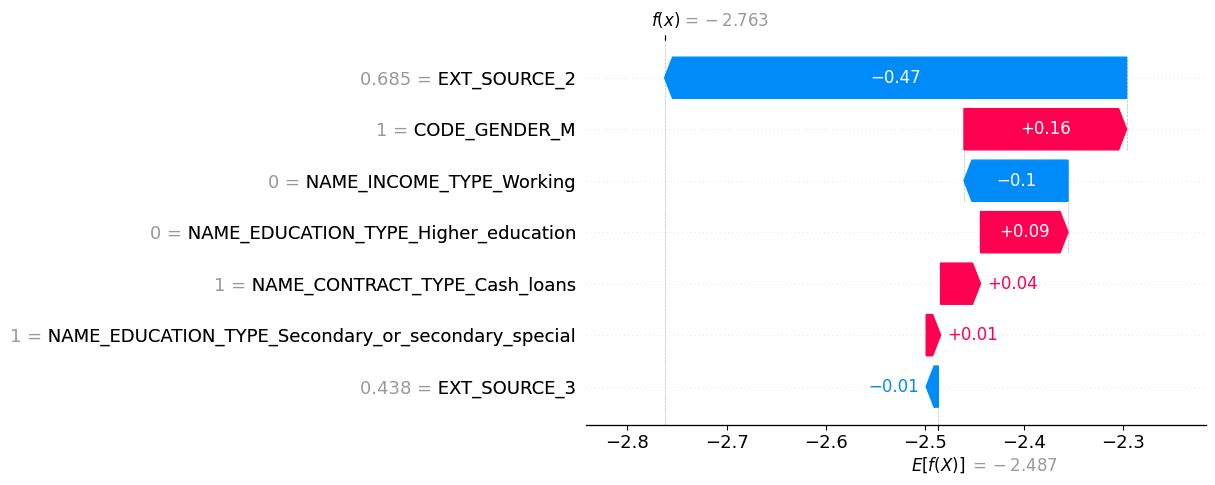

Expected class= 0
predicted probability= [0.3296032]


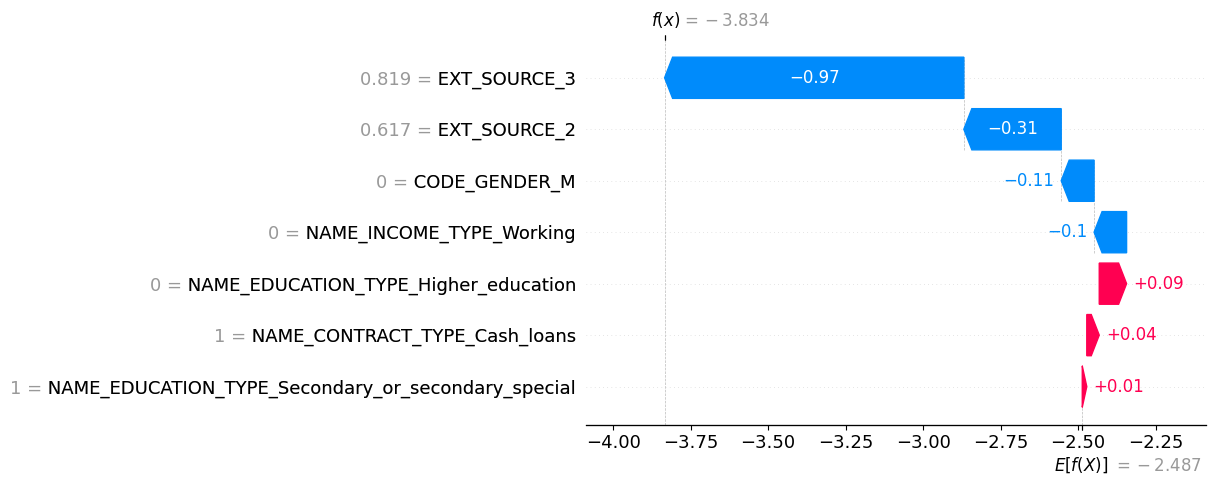

Expected class= 0
predicted probability= [0.6551919]


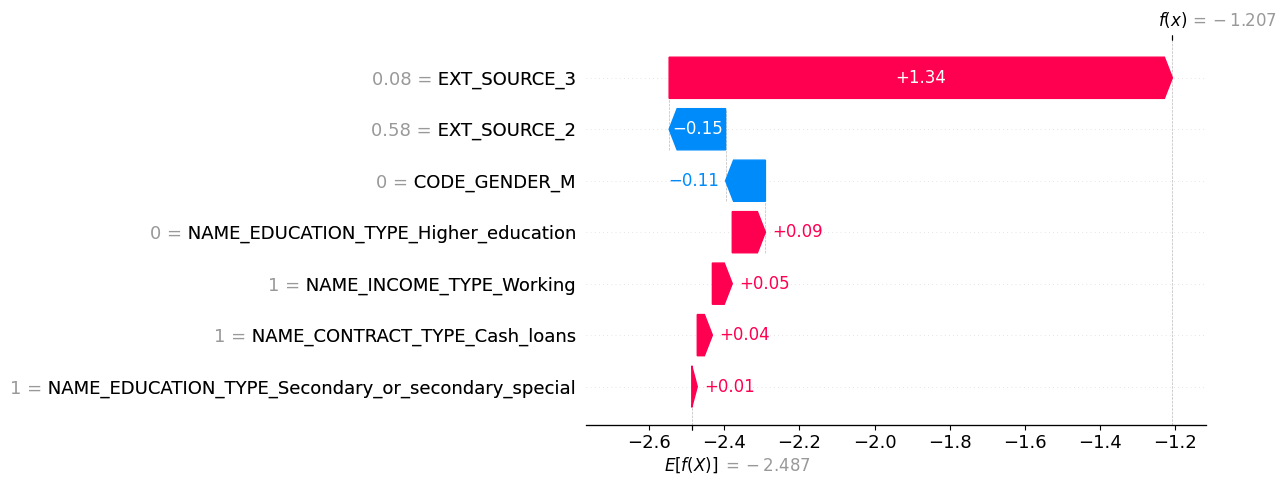

Expected class= 0
predicted probability= [0.43776947]


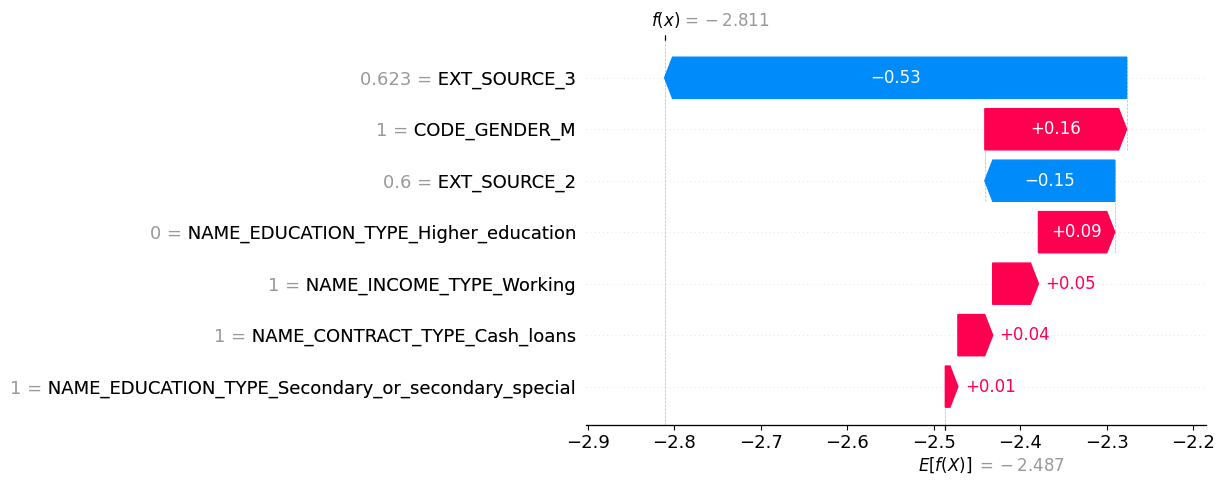

In [99]:
for idx in range(10) :
    df_X_sample1 = pd.DataFrame(df_X.iloc[idx]).T
    np_y_pred = model_prob.predict(df_X_sample1)
    print('Expected class=',  df_y.iloc[idx].values[0])
    print('predicted probability=', np_y_pred) #.round(3))
    shap.plots.waterfall(explainer(df_X)[idx], max_display=7)

# Fin du traitement

In [225]:
assert(False) # prevents the execution of following cells

AssertionError: 

# Annexes